In [43]:
from __future__ import print_function, division

import numpy as np
import gzip
from sklearn.preprocessing import LabelBinarizer

valid_labels = LabelBinarizer().fit_transform(
    np.array([float(x.decode("utf-8").split("\t")[1])
              for x in gzip.open("valid_labels.txt.gz",'rb')]))

In [44]:
parent_folders = ["flip-False_rotamt-0",
                  "flip-True_rotamt-0",
                  "flip-False_rotamt-90",
                  "flip-True_rotamt-90",
                  "flip-False_rotamt-180",
                  "flip-True_rotamt-180",]

parent_folder_to_det_pred = {}
for parent_folder in parent_folders:
    det_preds = np.array([
            [float(y) for y in x.decode("utf-8").split("\t")[1:]]
             for x in gzip.open(parent_folder+"/deterministic_preds.txt.gz", 'rb')])
    parent_folder_to_det_pred[parent_folder] = det_preds

In [45]:
def inverse_softmax(preds):
    return np.log(preds) - np.mean(np.log(preds),axis=1)[:,None]

pseudovalid_predictions = []
pseudovalid_labels = []
pseudovalid_label_counts = np.zeros(5)
pseudotest_predictions = []
pseudotest_labels = []
pseudotest_label_counts = np.zeros(5)
for i in range(int(0.5*len(valid_labels))):
    left_eye_label = valid_labels[2*i]
    right_eye_label = valid_labels[(2*i)+1]
    most_diseased_label = max(np.argmax(left_eye_label),
                              np.argmax(right_eye_label))
    if (pseudovalid_label_counts[most_diseased_label] <
        pseudotest_label_counts[most_diseased_label]):
        append_to_predictions = pseudovalid_predictions
        append_to_labels = pseudovalid_labels
        append_to_label_counts = pseudovalid_label_counts
    else:
        append_to_predictions = pseudotest_predictions
        append_to_labels = pseudotest_labels
        append_to_label_counts = pseudotest_label_counts
    
    for parent_folder in parent_folders:        
        append_to_labels.append(valid_labels[2*i])
        append_to_labels.append(valid_labels[(2*i)+1])
        append_to_label_counts += valid_labels[2*i]
        append_to_label_counts += valid_labels[(2*i)+1]
        append_to_predictions.append(
            parent_folder_to_det_pred[parent_folder][2*i])
        append_to_predictions.append(
            parent_folder_to_det_pred[parent_folder][(2*i)+1])
        
pseudovalid_predictions = np.array(pseudovalid_predictions)
pseudovalid_pred_logits = inverse_softmax(pseudovalid_predictions)
pseudovalid_labels = np.array(pseudovalid_labels)
pseudotest_predictions = np.array(pseudotest_predictions)
pseudotest_pred_logits = inverse_softmax(pseudotest_predictions)
pseudotest_labels = np.array(pseudotest_labels)
print(pseudovalid_label_counts,
      pseudotest_label_counts)

[7710.  750. 1608.  252.  228.] [7704.  738. 1608.  264.  222.]


In [46]:
import abstention

In [47]:
from abstention.calibration import compute_ece, TempScaling

print("ece before temp scale - valid",
      compute_ece(softmax_out=pseudovalid_predictions,
            labels=pseudovalid_labels,
            bins=15))
print("ece before temp scale - test",
      compute_ece(softmax_out=pseudotest_predictions,
            labels=pseudotest_labels,
            bins=15))

temp_scaler = TempScaling(ece_bins=15)(
                    valid_preacts=pseudovalid_pred_logits,
                    valid_labels=pseudovalid_labels)
temp_scaled_valid = temp_scaler(pseudovalid_pred_logits)
temp_scaled_test = temp_scaler(pseudotest_pred_logits)

print("ece after temp scale - valid",
      compute_ece(softmax_out=temp_scaled_valid,
            labels=pseudovalid_labels,
            bins=15))
print("ece after temp scale - test",
      compute_ece(softmax_out=temp_scaled_test,
            labels=pseudotest_labels,
            bins=15))

ece before temp scale - valid 5.508074793989377
ece before temp scale - test 6.932134963743351
Original NLL & grad is:  (15.247983008045903, array([-0.23344175]))
Original ECE is:  5.5080747301805655
      fun: 11.691330052458671
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.17832184e-09])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 7
      nit: 6
   status: 0
  success: True
        x: array([1.4003427])
Final NLL & grad is:  (11.691330052458671, array([-3.17832184e-09]))
Final ECE is:  1.7415015290279925
ece after temp scale - valid 1.7415015290279925
ece after temp scale - test 2.2930444310614932


In [53]:
import abstention.abstention
reload(abstention.abstention)
from abstention.abstention import (weighted_kappa_metric,
                                   WeightedKappa, DistMaxClassProbFromOne,
                                   Entropy)

quadratic_weights = np.array([[(i-j)**2 for i in range(5)]
                                   for j in range(5)])
print("Est valid perf",weighted_kappa_metric(predprobs=temp_scaled_valid,
                            true_labels=temp_scaled_valid,
                            weights=quadratic_weights))
print("Actual valid perf",weighted_kappa_metric(predprobs=temp_scaled_valid,
                            true_labels=pseudovalid_labels,
                            weights=quadratic_weights))
print("Est test perf",weighted_kappa_metric(predprobs=temp_scaled_test,
                            true_labels=temp_scaled_test,
                            weights=quadratic_weights))
print("Actual test perf",weighted_kappa_metric(predprobs=temp_scaled_test,
                            true_labels=pseudotest_labels,
                            weights=quadratic_weights))

abstainer_factories = [
    ("expected_weighted_kappa", WeightedKappa(weights=quadratic_weights)),
    ("dist_maxclass_prob_from_one", DistMaxClassProbFromOne()),
    ("entropy", Entropy())
]

for abstention_fraction in [0.05, 0.1, 0.15, 0.2]:
    print("\nabstention fraction:",abstention_fraction)
    for abstainer_name, abstainer_factory in abstainer_factories:
        abstainer = abstainer_factory(valid_labels=pseudovalid_labels,
                                      valid_posterior=temp_scaled_valid)
        abstainer_priorities = abstainer(temp_scaled_test)
        indices_to_retain = ([y[0] for y in sorted(enumerate(abstainer_priorities),
                              key=lambda x: x[1])][:int(len(abstainer_priorities)*
                                                           (1-abstention_fraction))])
        retained_temp_scaled_test = np.array([temp_scaled_test[i] for i in indices_to_retain])
        retained_pseudotest_labels = np.array([pseudotest_labels[i] for i in indices_to_retain])
        print("\nAbstention criterion:",abstainer_name)
        print("weighted kappa", weighted_kappa_metric(predprobs=retained_temp_scaled_test,
                                                      true_labels=retained_pseudotest_labels,
                                                      weights=quadratic_weights))
        print("accuracy", (np.sum(np.argmax(retained_temp_scaled_test,axis=-1)
                                  ==np.argmax(retained_pseudotest_labels,axis=-1))/
                           len(retained_pseudotest_labels)))
    


Est valid perf 0.8547677203019088
Actual valid perf 0.8251235688820109
Est test perf 0.8557382382958647
Actual test perf 0.8053019335151229

abstention fraction: 0.05

Abstention criterion: expected_weighted_kappa
weighted kappa 0.8363038689952988
accuracy 0.8356479168748127

Abstention criterion: dist_maxclass_prob_from_one
weighted kappa 0.8205600644777278
accuracy 0.846737935857728

Abstention criterion: entropy
weighted kappa 0.8225634485991846
accuracy 0.8419422519732241

abstention fraction: 0.1

Abstention criterion: expected_weighted_kappa
weighted kappa 0.8547271719574974
accuracy 0.8546720101244463

Abstention criterion: dist_maxclass_prob_from_one
weighted kappa 0.8188723625813382
accuracy 0.8658510862687196

Abstention criterion: entropy
weighted kappa 0.8334713773860338
accuracy 0.8625817338114322

abstention fraction: 0.15

Abstention criterion: expected_weighted_kappa
weighted kappa 0.8689956878404309
accuracy 0.8617532104969291

Abstention criterion: dist_maxclass_prob_

Platt scaling coef: 0.6994744423550331 ; intercept: -1.394499746231041


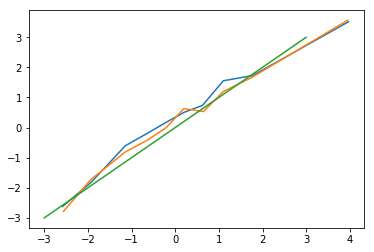

('Class', 0)
7449.458534168963
7343.749270547551


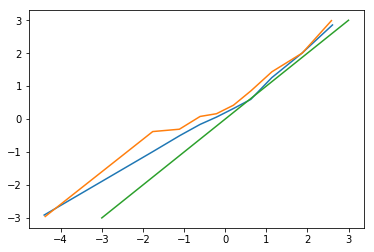

('Class', 1)
1043.3427834630563
1092.7740733087903


/Users/avantishrikumar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in divide


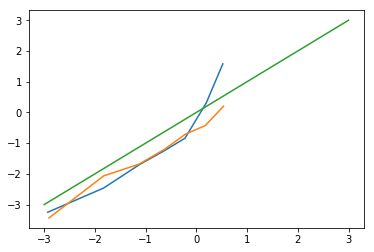

('Class', 2)
1193.9807690518987
1285.202628301794


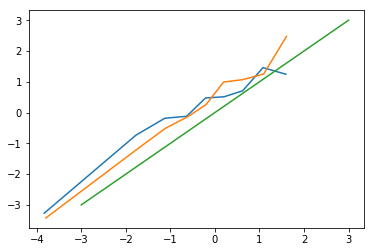

('Class', 3)
615.8134094403426
601.5930178107303


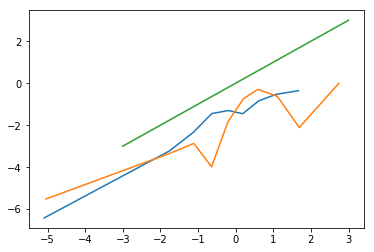

('Class', 4)
233.40450387574003
224.68101003113418


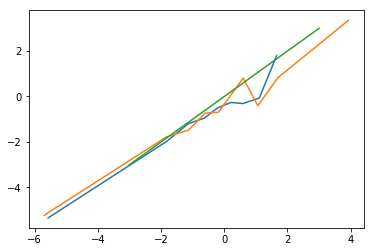

In [23]:
%matplotlib inline

platt_scaler = abstention.calibration.PlattScaling()(
                valid_preacts=pseudovalid_pred_logits[:,0],
                valid_labels=pseudovalid_labels[:,0])
platt_scaled_binary_valid = platt_scaler(pseudovalid_pred_logits[:,0])
platt_scaled_binary_test = platt_scaler(pseudotest_pred_logits[:,0])

fracpos, mpv = calibration_curve(
        y_true=1-pseudotest_labels[:,0],
        y_prob=1-platt_scaled_binary_test,
        n_bins=n_bins)
plt.plot(inverse_sigmoid(mpv), inverse_sigmoid(fracpos))
fracpos, mpv = calibration_curve(
        y_true=1-pseudovalid_labels[:,0],
        y_prob=1-platt_scaled_binary_valid,
        n_bins=n_bins)
plt.plot(inverse_sigmoid(mpv), inverse_sigmoid(fracpos))
plt.plot([-3,3],[-3,3])
plt.show()

def inverse_sigmoid(vals):
    return np.log(vals/(1-vals))

from sklearn.calibration import calibration_curve
from matplotlib import pyplot as plt
#plot the calibration curves for all 5 classes
n_bins=10
for i in range(5):
    print("Class",i)
    print(np.sum(temp_scaled_test[:,i]))
    print(np.sum(temp_scaled_valid[:,i]))
    fracpos, mpv = calibration_curve(
        y_true=pseudotest_labels[:,i],
        y_prob=temp_scaled_test[:,i],
        n_bins=n_bins)
    plt.plot(inverse_sigmoid(mpv), inverse_sigmoid(fracpos))
    fracpos, mpv = calibration_curve(
        y_true=pseudovalid_labels[:,i],
        y_prob=temp_scaled_valid[:,i],
        n_bins=n_bins)
    plt.plot(inverse_sigmoid(mpv), inverse_sigmoid(fracpos))
    plt.plot([-3,3],[-3,3])
    plt.show()


In [5]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

print("auROC",roc_auc_score(y_true=1.0*(augmented_labels > 0),
                                y_score=1.0-augmented_predictions[:,0]))
print("auPRC",average_precision_score(y_true=1.0*(augmented_labels > 0),
                                      y_score=1.0-augmented_predictions[:,0]))

for parent_folder in parent_folders:
    print(parent_folder)
    det_preds = parent_folder_to_det_pred[parent_folder]
    print("auROC",roc_auc_score(y_true=1.0*(valid_labels > 0),
                                y_score=1.0-det_preds[:,0]))
    print("auPRC",average_precision_score(y_true=1.0*(valid_labels > 0),
                                          y_score=1.0-det_preds[:,0]))


('auROC', 0.9110346557299545)
('auPRC', 0.8701437931231459)
flip-False_rotamt-0
('auROC', 0.9118638796723656)
('auPRC', 0.8741642180822626)
flip-True_rotamt-0
('auROC', 0.9136845292158645)
('auPRC', 0.8736448411305423)
flip-False_rotamt-90
('auROC', 0.9077797755493358)
('auPRC', 0.8644192149469085)
flip-True_rotamt-90
('auROC', 0.9072243126739039)
('auPRC', 0.8649775977946419)
flip-False_rotamt-180
('auROC', 0.916166708887612)
('auPRC', 0.8766635340690564)
flip-True_rotamt-180
('auROC', 0.9131712872857287)
('auPRC', 0.8712633844933214)


In [11]:
mc_preds = []
for i in range(100):
    nondet_preds = np.array([
        [float(y) for y in x.split("\t")[1:]]
         for x in gzip.open("flip-False_rotamt-0/nondeterministic_preds_"+str(i)+".txt.gz", 'rb')])
    mc_preds.append(nondet_preds)
mc_preds = np.array(mc_preds)

In [12]:
print(roc_auc_score(y_true=1.0*(valid_labels > 0),
                    y_score=1.0-np.mean(mc_preds,axis=0)[:,0]))
print(average_precision_score(y_true=1.0*(valid_labels > 0),
                    y_score=1.0-np.mean(mc_preds,axis=0)[:,0]))

0.9129881925522253
0.8745019026871873


flip-False_rotamt-0


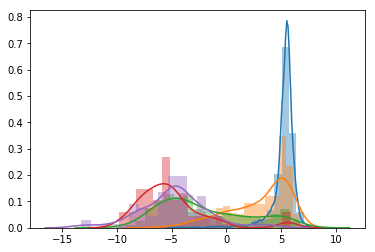

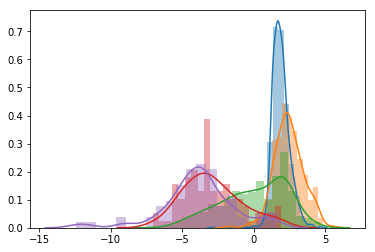

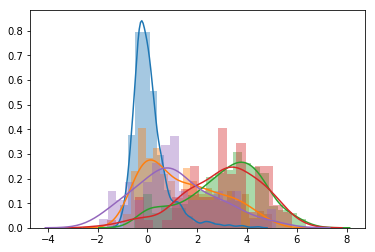

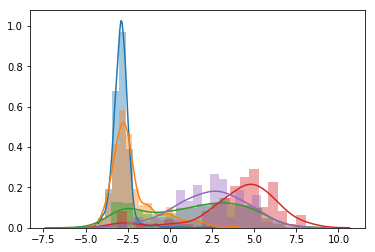

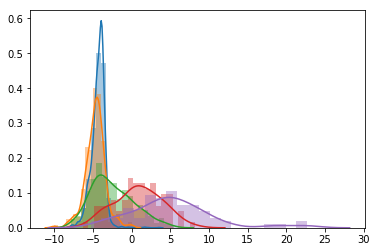

flip-True_rotamt-0


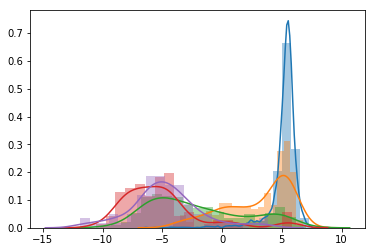

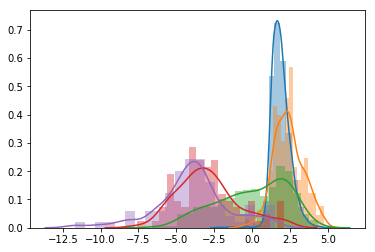

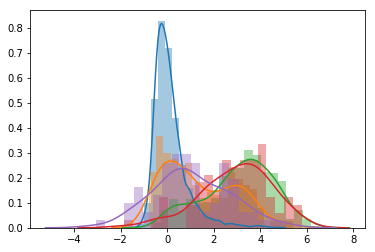

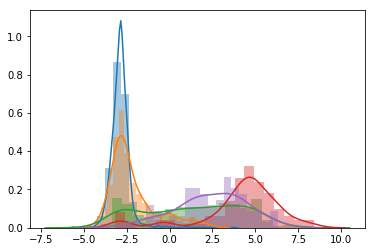

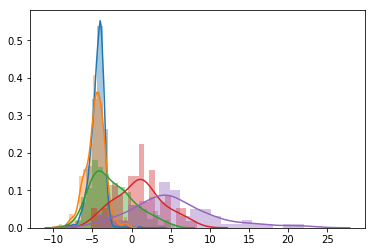

flip-False_rotamt-90


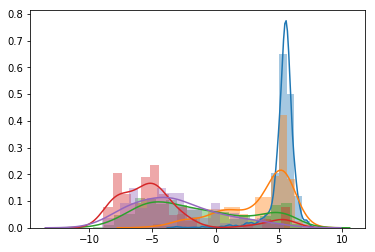

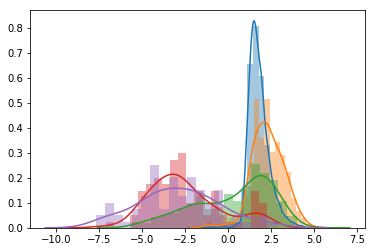

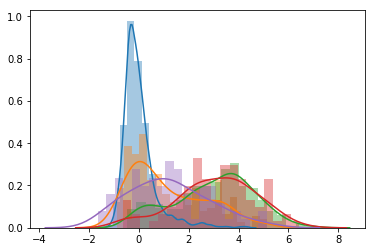

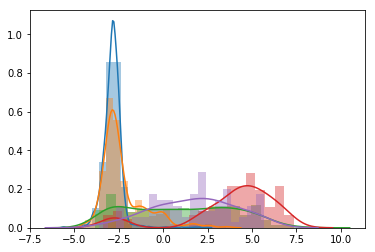

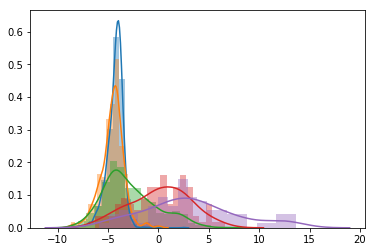

flip-True_rotamt-90


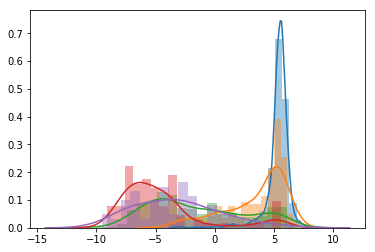

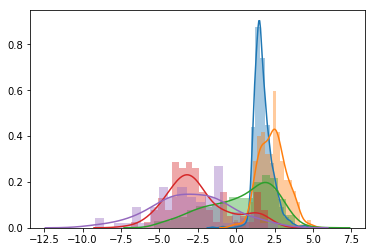

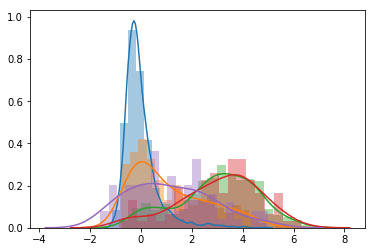

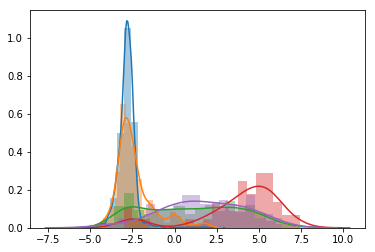

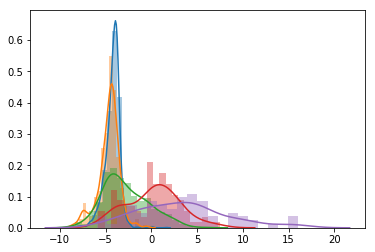

flip-False_rotamt-180


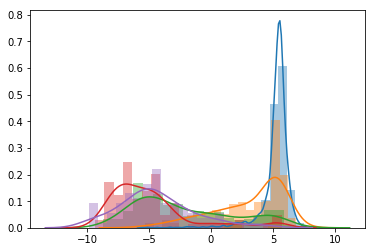

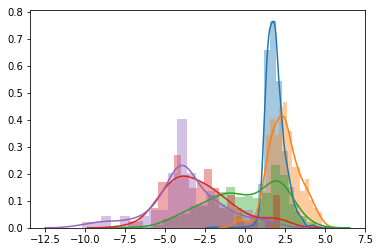

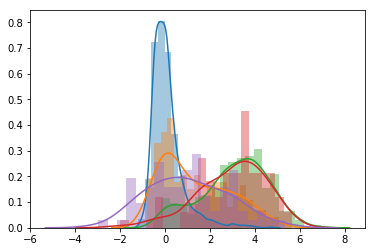

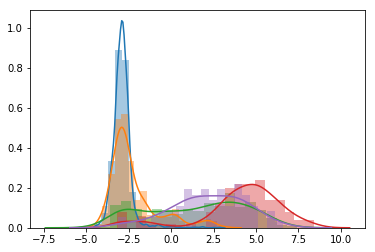

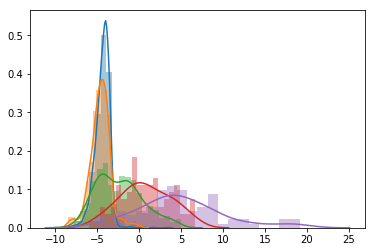

flip-True_rotamt-180


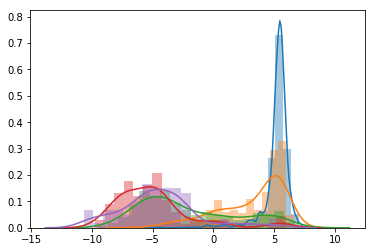

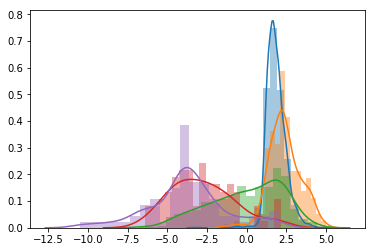

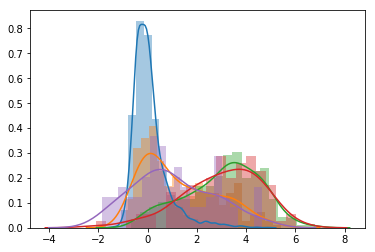

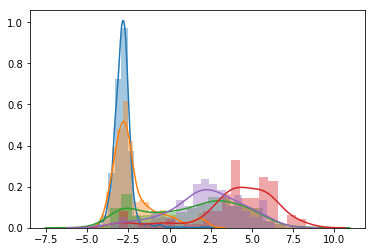

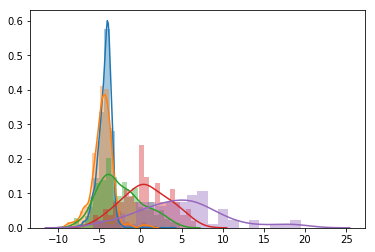

In [14]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

for parent_folder in parent_folders:
    print(parent_folder)
    preds = parent_folder_to_det_pred[parent_folder]
    #mean_mcpred = np.mean(mc_preds,axis=0)
    pred_logits = np.log(preds)
    pred_logits = pred_logits-np.mean(pred_logits,axis=1)[:,None]

    for i in range(5):
        sns.distplot(pred_logits[:,0][valid_labels==i],
                     bins=20)
    plt.show()
    for i in range(5):
        sns.distplot(pred_logits[:,1][valid_labels==i],
                     bins=20)
    plt.show()
    for i in range(5):
        sns.distplot(pred_logits[:,2][valid_labels==i],
                     bins=20)
    plt.show()
    for i in range(5):
        sns.distplot(pred_logits[:,3][valid_labels==i],
                     bins=20)
    plt.show()
    for i in range(5):
        sns.distplot(pred_logits[:,4][valid_labels==i],
                     bins=20)
    plt.show()